# Geneformer Fine-Tuning for Cell Annotation Application
![](./data/geneformer.png)

In this tutorial, we will demonstrate how to fine-tune model with Geneformer, and then, perform the cell classification task. We will use the author-provided cell type dataset to fine-tune the Geneformer model. We then apply the resulting model on the pancreas dataset described in the [scIB Github](https://github.com/theislab/scib) to infer cell type. 

There are 4 main steps mentioned in this notebook:

* Specify variables for the working environment
* Prepare training set for to finetune model
* Finetune Geneformer model
* Cell type inference from fine-tuned model


In case users do not want to run the training step, we also provide a prerun model here in the `pancreas_model` folder. Hence, users can directly investigate to the cell type inference step.

**TABLE OF CONTENT**

1. [Set up environment variables](#set-up-environment-variables)
2. [Input training data](#input-training-data)
3. [Fine-tune model](#fine-tune-model)
    1. [Set parameters to fine-tune model](#set-parameters-to-fine-tune-model)
    2. [Intialize model](#initialize-model)
    3. [Fine-tuning model](#fine-tuning-model)
4. [Evaluate the model](#evaluate-the-model)
5. [Cell type inference on new dataset](#cell-type-inference-on-new-dataset)
6. [References](#references)

In [1]:
import os
import subprocess
os.environ["NCCL_DEBUG"] = "INFO"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = ""

If users want to specify available free GPUs, execute the following code cell:

In [2]:
def find_gpus(nums=1):
    if nums == 1:
        return ['0']

    os.system('nvidia-smi -q -d Memory | grep Free >tmp_free_gpus')
    with open('tmp_free_gpus', 'r') as lines_txt:
        frees = lines_txt.readlines()
        idx_freeMemory_pair = [ (idx,int(x.split()[2]))
                              for idx,x in enumerate(frees) ]
    
    idx_freeMemory_pair_correct = []
    step = int(len(idx_freeMemory_pair) / nums)
    for i in range(0, len(idx_freeMemory_pair), step):
        obj = idx_freeMemory_pair[i]
        obj = (int(obj[0]/step), obj[1])
        idx_freeMemory_pair_correct.append(obj)
    
    idx_freeMemory_pair_correct.sort(key=lambda my_tuple:my_tuple[1],reverse=True)
    usingGPUs = [str(idx_memory_pair[0])
                    for idx_memory_pair in idx_freeMemory_pair_correct[:nums] ]

    print('using GPU idx: #', usingGPUs)
    return usingGPUs

n_gpus = str(subprocess.check_output(["nvidia-smi", "-L"])).count('UUID')
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(find_gpus(nums=n_gpus)[0])

using GPU idx: # ['0', '1', '2', '3']


In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import glob
import datetime
import numpy as np
import pandas as pd
from datasets import load_from_disk, Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from collections import defaultdict
from geneformer import Classifier, EmbExtractor

## Set up environment variables

Some functions in `Geneformer` analysis pipeline requires to use the absolute paths, hence, we indicate the way to setting up environment variables here.

Users can select to use the 12-layer Geneformer model or the 6-layer Geneformer. 

In [4]:
import sys, os
LIB_PATH=sys.path[1].split("/lib/")[0]
LFS_HOME=f"{LIB_PATH}/bin/git-lfs"
print(LFS_HOME)
# os.system(f"{LFS_HOME} install")
# os.system(f"{LFS_HOME} clone https://huggingface.co/ctheodoris/Geneformer")
# os.system(f"cd ./Geneformer && {LFS_HOME} pull")

/home/tripham/anaconda3/envs/geneformer_env/bin/git-lfs


In [5]:
# Current working directory
cwd = os.getcwd()
print("cwd:", cwd)
# Path to Geneformer directory
repo_dir = os.path.join(cwd, "Geneformer")
print("repo_dir:", repo_dir)
# Path to dictionaries in geneformer repo
dict_dir = os.path.join(repo_dir, "Geneformer")
print("dict_dir:", dict_dir)
# Pre-train model directory
# pre_model_dir = glob.glob(os.path.join(repo_dir, "*-12L-30M*"))[0]   ### use 12-layer Geneformer model
# print(os.path.join(repo_dir, "*-6L-30M*"))
pre_model_dir = glob.glob(os.path.join(repo_dir, "*-6L-30M*"))[0]  ### use 6-layer Geneformer model
print("pre_model_dir:", pre_model_dir)
# Input data path
input_dir = os.path.join(cwd, "data")
print("input_dir:", input_dir)
# Output directory
output_dir = os.path.join(cwd, "outputs")
print("output_dir:", output_dir)
# Input data set path 
input_prefix = "pancreas_scib"


cwd: /home/tripham/geneformer_test/geneform-rev2-1d7931c-2025322-59436
repo_dir: /home/tripham/geneformer_test/geneform-rev2-1d7931c-2025322-59436/Geneformer
dict_dir: /home/tripham/geneformer_test/geneform-rev2-1d7931c-2025322-59436/Geneformer/Geneformer
pre_model_dir: /home/tripham/geneformer_test/geneform-rev2-1d7931c-2025322-59436/Geneformer/gf-6L-30M-i2048
input_dir: /home/tripham/geneformer_test/geneform-rev2-1d7931c-2025322-59436/data
output_dir: /home/tripham/geneformer_test/geneform-rev2-1d7931c-2025322-59436/outputs


In [6]:
# Create folder outputs
if not os.path.exists(output_dir):
   os.makedirs(output_dir)

## Input training data

Before running this notebook, please run `download_and_prepare_datasets` notebook to get the data.

In [7]:
print(f"{input_dir}/cell_type_train_data.dataset")
print(f"{input_dir}/{input_prefix}.dataset")
print(f"{input_dir}/{input_prefix}_filtered.dataset")

/home/tripham/geneformer_test/geneform-rev2-1d7931c-2025322-59436/data/cell_type_train_data.dataset
/home/tripham/geneformer_test/geneform-rev2-1d7931c-2025322-59436/data/pancreas_scib.dataset
/home/tripham/geneformer_test/geneform-rev2-1d7931c-2025322-59436/data/pancreas_scib_filtered.dataset


In [8]:
# Load and shuffle the dataset
cell_type_train_data = load_from_disk(f"{input_dir}/cell_type_train_data.dataset")
cell_type_train_data = cell_type_train_data.shuffle(seed=42)
cell_type_train_data_df = cell_type_train_data.to_pandas()
# Create a unique identifier for each cell
cell_type_train_data_df['cell_id'] = cell_type_train_data_df.index.astype(str)
cell_type_train_data_df

,cell_type,input_ids,length,organ_major,cell_id
0,Erythroid progenitor cell (RP high),"[13083, 11949, 20281, 16714, 11536, 52, 920, 1...",1095,liver,0
1,AT2 cell,"[10654, 16926, 21170, 17201, 8034, 12163, 833,...",434,lung,1
2,T cell,"[5541, 21200, 13037, 5921, 6268, 14327, 9027, ...",413,immune,2
3,Antigen presenting cell (RPS high),"[18822, 23878, 12406, 12515, 6226, 7993, 10461...",369,immune,3
4,Fetal epithelial progenitor,"[12913, 10132, 3984, 4122, 11790, 5536, 13227,...",500,lung,4
...,...,...,...,...,...
249551,Fetal enterocyte,"[11172, 1675, 11536, 2007, 2010, 16264, 7891, ...",710,large_intestine,249551
249552,Loop of Henle,"[12445, 18480, 21562, 4685, 16894, 8981, 16211...",663,kidney,249552
249553,Erythroid progenitor cell (RP high),"[20758, 24379, 10427, 12173, 1293, 2570, 17009...",239,liver,249553
249554,Neutrophil,"[16714, 11396, 5625, 467, 12189, 1223, 12125, ...",702,liver,249554


- Biological datasets often contain samples from multiple tissues or organs. Each tissue can have its own distribution of cell types, expression profiles. By splitting the data by `"organ_major"`, users can isolate each tissue’s cells and their distinct patterns.

- Within each tissue group, some cell types might appear very infrequently (e.g., under 0.5% of the total cells). Removing these underrepresented cell types helps ensure more balanced classes for training and evaluation. This step reduces noise and avoids issues with having too few samples of a particular cell type.

- After filtering, the data is split into training, evaluation, and test subsets (70–15–15). This is a standard practice to:

    - Train the model on the training set
    - Tune hyperparameters or monitor performance on the evaluation set
    - Finally, measure the model’s generalization on the test set


In [9]:
# Process each organ_major group
results = {} 

for organ, group in cell_type_train_data_df.groupby('organ_major'): # Group by organ_major
    # We will ilter out cell types with less than 0.5% of the total cells in the current organ
    total_cells = len(group)
    threshold = total_cells * 0.005  # 0.5% threshold

    counts = group['cell_type'].value_counts()
    allowed_types = counts[counts >= threshold].index.tolist()

    # Filter out cell types below the threshold
    filtered_group = group[group['cell_type'].isin(allowed_types)].copy()
    n_unique = filtered_group['cell_type'].nunique()
    
    # Perform a 70-15-15 split
    if n_unique >= 2:
        # Stratified split to maintain cell_type proportions
        train_group, temp_group = train_test_split(
            filtered_group,
            test_size=0.30,
            stratify=filtered_group['cell_type'],
            random_state=42
        )
        eval_group, test_group = train_test_split(
            temp_group,
            test_size=0.5,
            stratify=temp_group['cell_type'],
            random_state=42
        )
    else:
        # If only one cell type remains, do a simple random split
        indices = filtered_group.index.to_numpy()
        np.random.seed(42)
        np.random.shuffle(indices)
        n = len(indices)
        n_train = int(n * 0.7)
        n_eval = int(n * 0.15)
        train_group = filtered_group.loc[indices[:n_train]]
        eval_group = filtered_group.loc[indices[n_train:n_train+n_eval]]
        test_group = filtered_group.loc[indices[n_train+n_eval:]]
    
    results[organ] = {
        'train_ids': train_group['cell_id'].tolist(),
        'train_labels': train_group['cell_type'].tolist(),
        'train_input_ids': train_group['input_ids'].tolist(),
        'train_length': train_group['length'].tolist(),
        'eval_ids': eval_group['cell_id'].tolist(),
        'eval_labels': eval_group['cell_type'].tolist(),
        'eval_input_ids': eval_group['input_ids'].tolist(),
        'eval_length': eval_group['length'].tolist(),
        'test_ids': test_group['cell_id'].tolist(),
        'test_labels': test_group['cell_type'].tolist(),
        'test_input_ids': test_group['input_ids'].tolist(),
        'test_length': test_group['length'].tolist()
    }

    print(f"Organ: {organ}")
    print()

Organ: bone_marrow

Organ: brain

Organ: immune

Organ: kidney

Organ: large_intestine

Organ: liver

Organ: lung

Organ: pancreas

Organ: placenta

Organ: spleen



`Note: Although this example focuses on the pancreas, users also have the option to fine-tune on the entire organ or the other organ.`

In [10]:
CHOSEN_TISSUE = 'pancreas'
pancreas_results = results[CHOSEN_TISSUE]

pancreas_data = {
    "cell_id": pancreas_results["train_ids"] +
               pancreas_results["eval_ids"] +
               pancreas_results["test_ids"],
    "cell_type": pancreas_results["train_labels"] +
                 pancreas_results["eval_labels"] +
                 pancreas_results["test_labels"],
    "input_ids": pancreas_results["train_input_ids"] +
                 pancreas_results["eval_input_ids"] +
                 pancreas_results["test_input_ids"],
    "length": pancreas_results["train_length"] +
              pancreas_results["eval_length"] +
              pancreas_results["test_length"],
    "split": ["train"] * len(pancreas_results["train_ids"]) +
             ["eval"] * len(pancreas_results["eval_ids"]) +
             ["test"] * len(pancreas_results["test_ids"])
}

pancreas_ds = Dataset.from_dict(pancreas_data)
pancreas_ds.save_to_disk(f"{output_dir}/{input_prefix}_labeled.dataset")
pancreas_ds

Dataset({
    features: ['cell_id', 'cell_type', 'input_ids', 'length', 'split'],
    num_rows: 27418
})

In [11]:
pancreas_ds_df = pancreas_ds.to_pandas()
# Create a unique identifier for each cell
pancreas_ds_df

,cell_id,cell_type,input_ids,length,split
0,4384,T cell,"[18653, 10402, 11267, 12243, 15340, 13080, 138...",322,train
1,185238,Pancreas exocrine cell,"[5982, 21437, 22079, 21314, 16700, 20390, 1282...",589,train
2,153117,Pancreas exocrine cell,"[16489, 21319, 11664, 7724, 13714, 9758, 12141...",201,train
3,183246,T cell,"[10427, 5629, 10391, 6417, 5661, 2407, 7109, 1...",277,train
4,35626,Fetal acinar cell,"[4074, 20055, 23676, 13085, 12891, 20516, 2045...",358,train
...,...,...,...,...,...
27413,221960,Fetal endocrine cell,"[24443, 17259, 538, 6582, 2297, 1304, 10367, 8...",540,test
27414,162468,Enterocyte progenitor,"[6491, 12945, 11138, 10114, 1671, 5400, 12241,...",305,test
27415,247222,B cell,"[7382, 2823, 743, 7557, 15351, 3911, 6243, 120...",425,test
27416,117927,Pancreas exocrine cell,"[24457, 219, 7891, 22079, 11352, 21314, 5502, ...",505,test


In [12]:
print(len(pancreas_ds[0]['input_ids']))

322


In [13]:
print(type(pancreas_results["train_labels"]))
unique_cell_types = set(pancreas_results["train_labels"])
print(unique_cell_types) # 15 cell types

<class 'list'>
{'Fetal neuron', 'Pancreas exocrine cell', 'T cell', 'Enterocyte progenitor', 'B cell', 'Fetal endocrine cell', 'Fetal mesenchymal progenitor', 'Smooth muscle cell', 'Fetal acinar cell', 'Macrophage', 'Dendritic cell', 'Fetal epithelial progenitor', 'Endothelial cell (APC)', 'Endothelial cell', 'Erythroid cell'}


In [14]:
# Save the test dataset to disk
pancreas_test_dataset = Dataset.from_dict({
    "cell_id": pancreas_results["test_ids"],
    "cell_type": pancreas_results["test_labels"],
    "input_ids": pancreas_results["test_input_ids"],
    "length": pancreas_results["test_length"]
})

pancreas_test_dataset.save_to_disk(f"{output_dir}/{input_prefix}_labeled_test.dataset")

# Save the train dataset to disk
pancreas_train_dataset = Dataset.from_dict({
    "cell_id": pancreas_results["train_ids"] +
               pancreas_results["eval_ids"],
    "cell_type": pancreas_results["train_labels"] +
                 pancreas_results["eval_labels"],
    "input_ids": pancreas_results["train_input_ids"] +
                 pancreas_results["eval_input_ids"],
    "length": pancreas_results["train_length"] +
              pancreas_results["eval_length"]
})

pancreas_train_dataset.save_to_disk(f"{output_dir}/{input_prefix}_labeled_train.dataset")

In [15]:
# Load dataset from disk to verify
pancreas_test_dataset = load_from_disk(f"{output_dir}/{input_prefix}_labeled_test.dataset")
print(pancreas_test_dataset)
pancreas_train_dataset = load_from_disk(f"{output_dir}/{input_prefix}_labeled_train.dataset")
print(pancreas_train_dataset)

Dataset({
    features: ['cell_id', 'cell_type', 'input_ids', 'length'],
    num_rows: 4113
})
Dataset({
    features: ['cell_id', 'cell_type', 'input_ids', 'length'],
    num_rows: 23305
})


This top_5_celltypes will be used to filter the confusion matrix plot

In [16]:
top_5_celltypes = pancreas_ds_df['cell_type'].value_counts().head(5).index.values
top_5_celltypes

array(['T cell', 'Pancreas exocrine cell', 'Enterocyte progenitor',
       'Fetal acinar cell', 'Fetal mesenchymal progenitor'], dtype=object)

## Fine-tune model

### Set parameters to fine-tune model

In [17]:
cellformer_batch_size = 4  # The higher batch_size, the faster model training/inference but cost more GPU usage
num_proc = 16  # Number of processes for parallelism

# Define training and runtime parameters
training_args = {
    "per_device_train_batch_size": cellformer_batch_size,
    "per_device_eval_batch_size": cellformer_batch_size,
    "num_train_epochs": 0.9,
    "learning_rate": 0.00087,
    "lr_scheduler_type": "polynomial",
    "warmup_steps": 1812,
    "weight_decay":0.02828,
    "seed": 73,
    # add other training hyperparameters as needed
}

### Initialize model

Using cell_type as labels for fine-tuning Cell Annotation

In [18]:
cc = Classifier(
    classifier="cell",
    cell_state_dict = {"state_key": "cell_type", "states": "all"},
    training_args=training_args,
    max_ncells=None,
    freeze_layers = 2,
    num_crossval_splits = 1,
    stratify_splits_col="cell_type",
    forward_batch_size=cellformer_batch_size,
    # rare_threshold=0.005,
    nproc=num_proc,
    ngpu=1
)

Assign dataset to the Classifier

In [19]:
train_test_id_split_dict = {
    "attr_key": "split",
    "train": ['train', 'eval'],
    "test": ['test']
}
# Generate file pancreas_scib_id_class_dict.pkl
cc.prepare_data(
    input_data_file=f"{output_dir}/{input_prefix}_labeled.dataset",
    output_directory=output_dir,
    output_prefix=input_prefix,
    split_id_dict=train_test_id_split_dict
)

In [20]:
# Load dataset from disk to verify
pancreas_test_dataset = load_from_disk(f"{output_dir}/{input_prefix}_labeled_test.dataset")
print(pancreas_test_dataset)
pancreas_train_dataset = load_from_disk(f"{output_dir}/{input_prefix}_labeled_train.dataset")
print(pancreas_train_dataset)

Dataset({
    features: ['cell_id', 'label', 'input_ids', 'length', 'split'],
    num_rows: 4113
})
Dataset({
    features: ['cell_id', 'label', 'input_ids', 'length', 'split'],
    num_rows: 23305
})


### Fine-tuning model

In [22]:
train_valid_id_split_dict = {
    "attr_key": "split",
    "train": ['train'],
    "eval": ['eval']
}

all_metrics = cc.validate(
    model_directory=pre_model_dir,
    prepared_input_data_file=f"{output_dir}/{input_prefix}_labeled_train.dataset",
    id_class_dict_file=f"{output_dir}/{input_prefix}_id_class_dict.pkl",
    output_directory=output_dir,
    output_prefix=input_prefix,
    split_id_dict=train_valid_id_split_dict
)

  0%|          | 0/1 [00:00<?, ?it/s]

Some weights of the model checkpoint at /home/tripham/geneformer_test/geneform-rev2-1d7931c-2025322-59436/Geneformer/gf-6L-30M-i2048 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /home/tripham/gene

****** Validation split: 1/1 ******



wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: phamthanhtri-id2020 (phamthanhtri-ho-chi-minh-city-university-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/home/tripham/anaconda3/envs/geneformer_env/lib/python3.10/site-packages/geneformer/collator_for_classification.py:644: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
0,0.292000,0.272362,0.925845,0.857488


  0%|          | 0/1028 [00:00<?, ?it/s]

## Evaluate the model

Let us load the above fine-tuned model

In [23]:
cc = Classifier(
    classifier="cell",
    cell_state_dict = {"state_key": "cell_type", "states": "all"},
    forward_batch_size=cellformer_batch_size,
    nproc=num_proc
)

Hyperparameter tuning is highly recommended for optimal results. No training_args provided; using default hyperparameters.


In [24]:
pancreas_test_dataset_df = pancreas_test_dataset.to_pandas()
pancreas_test_dataset_df

,cell_id,label,input_ids,length,split
0,156324,14,"[9800, 5566, 7891, 11953, 1268, 1913, 5045, 41...",451,test
1,72802,1,"[21437, 2187, 7190, 22079, 6768, 21314, 7582, ...",212,test
2,177143,1,"[6057, 20583, 13516, 10114, 9926, 2056, 1485, ...",304,test
3,48599,4,"[4359, 15191, 24529, 12100, 17253, 10201, 1092...",240,test
4,241818,13,"[4365, 10607, 8242, 8810, 7357, 12224, 4429, 2...",409,test
...,...,...,...,...,...
4108,234887,10,"[4040, 3555, 7496, 1681, 5107, 15118, 7350, 10...",1196,test
4109,175354,10,"[20648, 1718, 24647, 21521, 15944, 658, 11790,...",915,test
4110,52287,2,"[6526, 432, 5031, 9642, 14354, 498, 12620, 130...",359,test
4111,134383,8,"[7350, 6526, 9489, 2570, 17933, 10577, 10168, ...",355,test


After running inference on the test data, it generates performance metrics (such as accuracy, precision, recall) and a confusion matrix. The results are stored in all_metrics_test.

In [25]:
current_date = datetime.datetime.now()
datestamp_min = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"
model_directory = f"{output_dir}/{datestamp_min}_geneformer_cellClassifier_{input_prefix}/ksplit1/"

# Saved at pancreas_scib_test_metrics_dict.pkl
# and pancreas_scib_pred_dict.pkl (call to cc.evaluate_model function)
all_metrics_test = cc.evaluate_saved_model(
        model_directory=model_directory,
        id_class_dict_file=f"{output_dir}/{input_prefix}_id_class_dict.pkl",
        test_data_file=f"{output_dir}/{input_prefix}_labeled_test.dataset",
        output_directory=output_dir,
        output_prefix=input_prefix,
    )

  0%|          | 0/1028 [00:00<?, ?it/s]

Plotting the Confusion Matrix

The confusion matrix is a powerful visualization that highlights how well the model distinguishes each cell type from the others. It helps identify where the model might be confusing similar classes or performing particularly well (or poorly).

<Figure size 1000x1000 with 0 Axes>

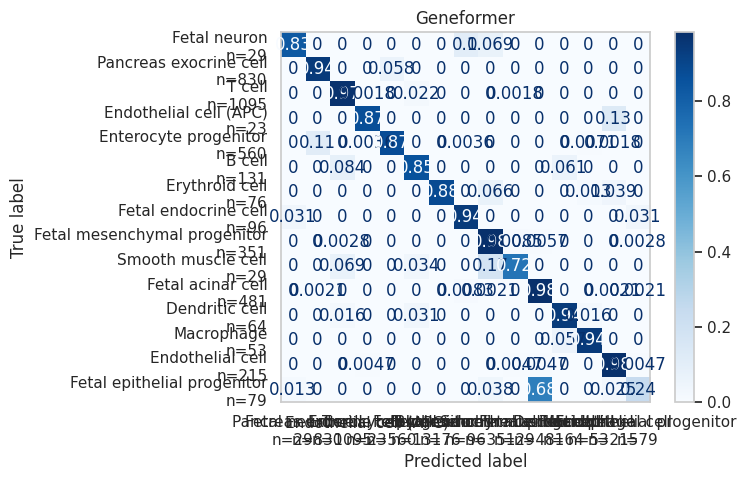

In [26]:
cc.plot_conf_mat(
        conf_mat_dict={"Geneformer": all_metrics_test["conf_matrix"]},
        output_directory=output_dir,
        output_prefix=input_prefix,
        # custom_class_order=top_5_celltypes,
)
# Saved at file pancreas_scib_conf_mat.pdf

<Figure size 1500x1500 with 0 Axes>

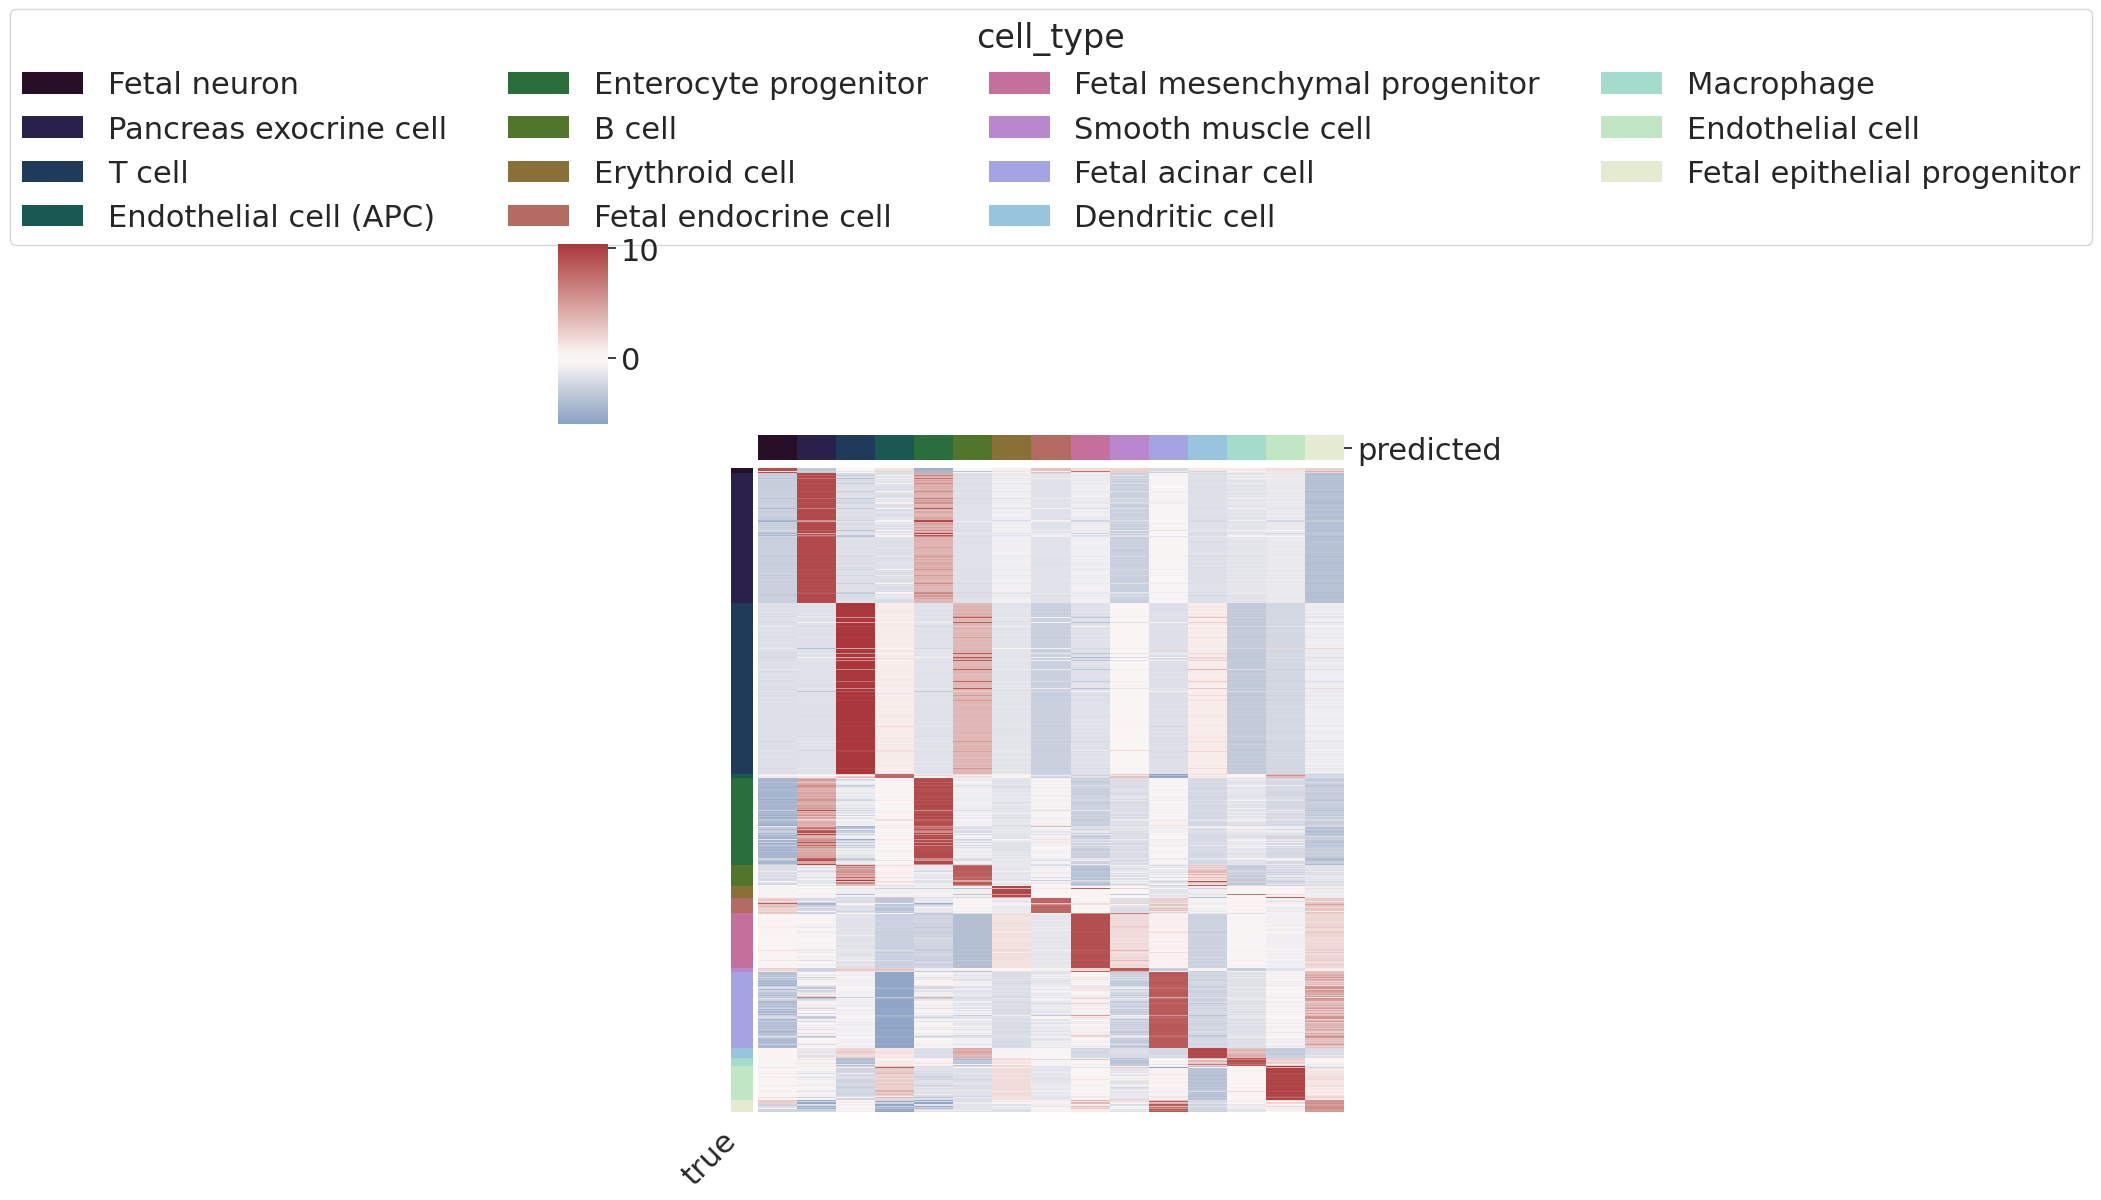

In [27]:
cc.plot_predictions(
    predictions_file=f"{output_dir}/{input_prefix}_pred_dict.pkl",
    id_class_dict_file=f"{output_dir}/{input_prefix}_id_class_dict.pkl",
    title="cell_type",
    output_directory=output_dir,
    output_prefix=input_prefix,
    # custom_class_order=top_5_celltypes,
)
# Saved at file pancreas_scib_pred.pdf

Performance metrics

In [28]:
all_metrics_test['conf_matrix']

,Fetal neuron,Pancreas exocrine cell,T cell,Endothelial cell (APC),Enterocyte progenitor,B cell,Erythroid cell,Fetal endocrine cell,Fetal mesenchymal progenitor,Smooth muscle cell,Fetal acinar cell,Dendritic cell,Macrophage,Endothelial cell,Fetal epithelial progenitor
Fetal neuron,24,0,0,0,0,0,0,3,2,0,0,0,0,0,0
Pancreas exocrine cell,0,782,0,0,48,0,0,0,0,0,0,0,0,0,0
T cell,0,0,1067,2,0,24,0,0,0,2,0,0,0,0,0
Endothelial cell (APC),0,0,0,20,0,0,0,0,0,0,0,0,0,3,0
Enterocyte progenitor,0,62,0,2,489,0,0,2,0,0,0,0,4,1,0
B cell,0,0,11,0,0,112,0,0,0,0,0,8,0,0,0
Erythroid cell,0,0,0,0,0,0,67,0,5,0,0,0,1,3,0
Fetal endocrine cell,3,0,0,0,0,0,0,90,0,0,0,0,0,0,3
Fetal mesenchymal progenitor,0,0,1,0,0,0,0,0,344,3,2,0,0,0,1
Smooth muscle cell,0,0,2,0,0,1,0,0,5,21,0,0,0,0,0


In [29]:
all_metrics_test['macro_f1']

np.float64(0.8642441888145053)

In [30]:
all_metrics_test['acc']

0.9311770428015564

## Cell type inference on old dataset

In [31]:
# The new dataset contains lots of strange labels, which are not in the original dataset
# Testing on the old test dataset instead

In [32]:
embex = EmbExtractor(
    model_type="CellClassifier",
    emb_mode='cell',
    num_classes=15,
    max_ncells=sys.maxsize,
    emb_layer=0,
    emb_label=['cell_id', 'cell_type', 'input_ids', 'length'],
    labels_to_plot=["cell_type"],
    forward_batch_size=cellformer_batch_size,
    nproc=num_proc,
)

In [33]:
print(pancreas_ds)

Dataset({
    features: ['cell_id', 'cell_type', 'input_ids', 'length', 'split'],
    num_rows: 27418
})


In [34]:
embs = embex.extract_embs(
    model_directory=model_directory,
    input_data_file=f"{output_dir}/pancreas_scib_labeled.dataset/",
    output_directory=output_dir,
    output_prefix='pancraes_scib_new'
)
print(type(embs))

CLS token present in token dictionary, excluding from average.
EOS token present in token dictionary, excluding from average.


  0%|          | 0/6855 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>


In [35]:
print(embs.head())

          0         1         2         3         4         5         6  \
0 -0.892934 -1.140851 -1.027826 -0.005822  1.716904 -1.718568 -0.222821   
1 -1.126063 -0.244087 -0.698073 -0.332490  0.752915  0.020857 -0.229835   
2 -1.179258 -0.064850 -0.595182 -0.382579  0.697559 -0.104879 -0.214752   
3 -1.457245 -0.159218 -0.679608 -0.282977  0.488890  0.114385 -0.233531   
4 -2.197071  0.304593 -0.077870  0.124565 -0.922938  0.564254  1.114194   

          7         8         9  ...       250       251       252       253  \
0  0.039031  0.864443  0.366518  ...  0.769372  1.087013 -0.961851  2.731178   
1 -0.565730  0.824277 -1.541623  ...  0.925457 -0.146201 -2.289676  0.750893   
2 -0.847098  0.936075 -1.480165  ...  0.872138 -0.120356 -2.031905  0.728333   
3 -0.500719  1.015982 -1.743103  ...  0.706705  0.140230 -2.096791  0.473251   
4  0.101352 -0.443391 -1.087114  ... -0.268071  1.036306 -0.499742  0.736027   

        254       255  cell_id          cell_type  \
0 -0.182062 -1.

In [36]:
embedding = embs.iloc[:, :256].values
metadata_df = embs.iloc[:, 255:]

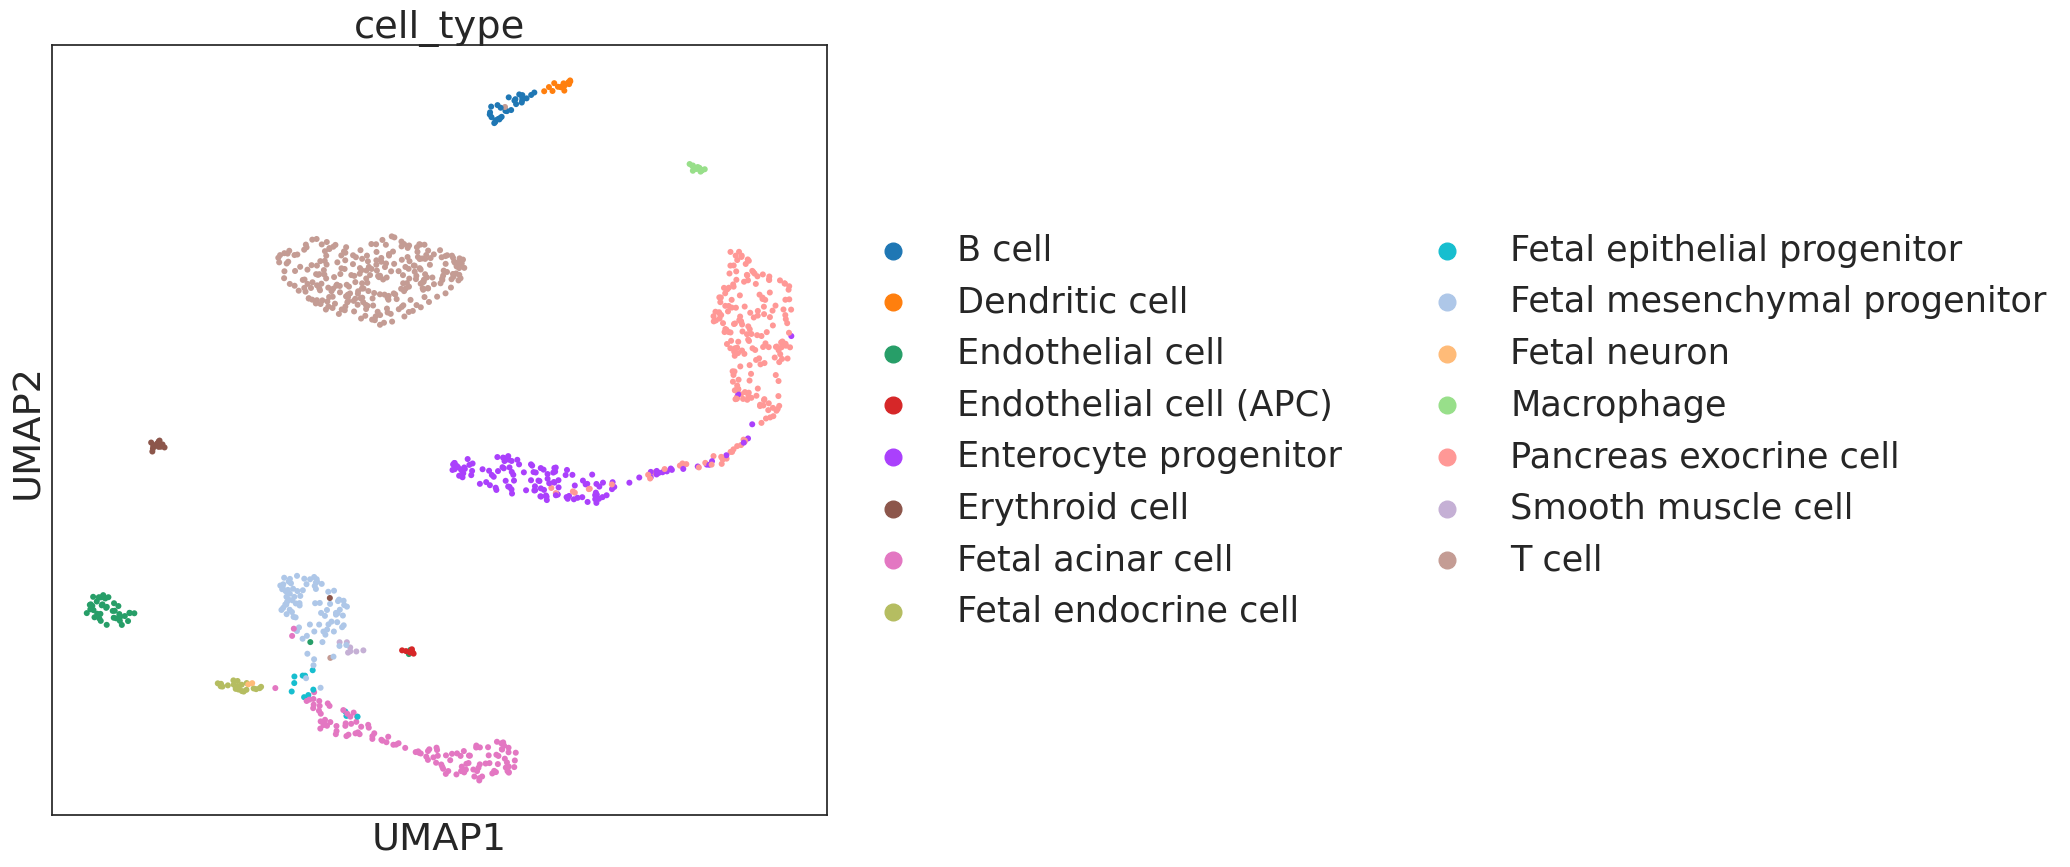

<Figure size 1000x1000 with 0 Axes>

In [37]:
embex.plot_embs(embs=embs, 
                plot_style="umap",
                output_directory="outputs",  
                output_prefix="emb_plot")
# Saved to emb_plot_umap_cell_type.pdf

/home/tripham/.local/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/tripham/.local/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 2250x2250 with 0 Axes>

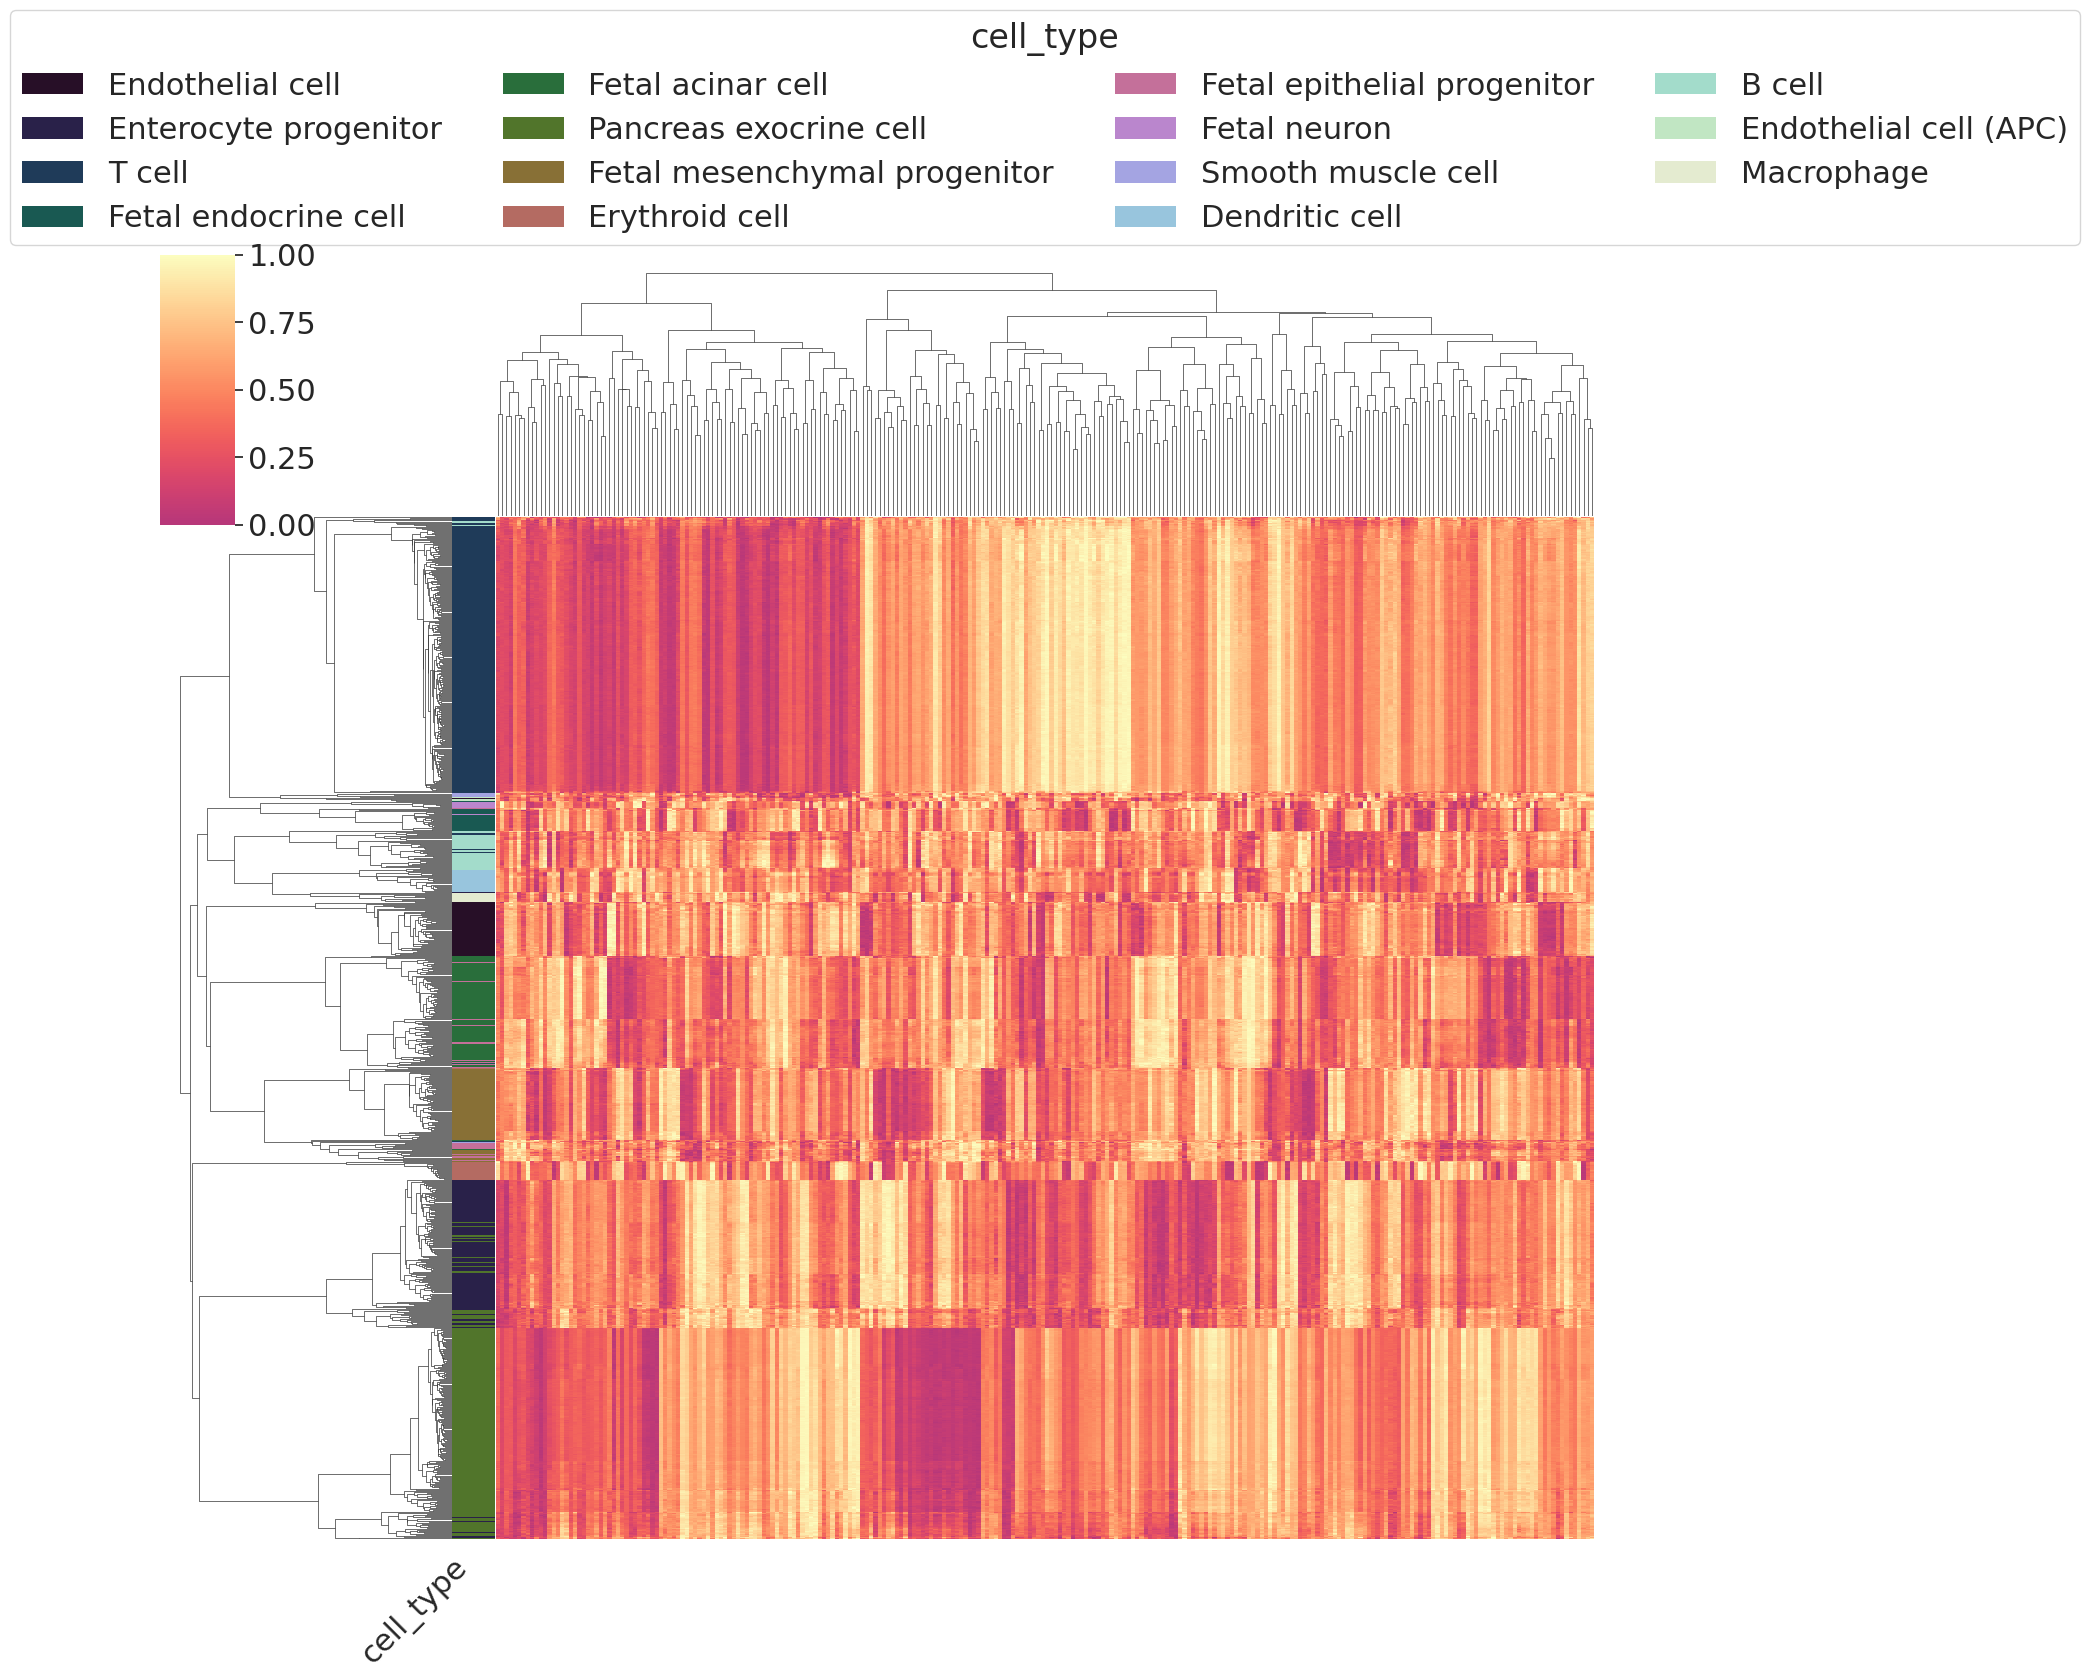

<Figure size 1000x1000 with 0 Axes>

In [38]:
# plot heatmap of cell embeddings
embex.plot_embs(embs=embs, 
                plot_style="heatmap",
                output_directory="outputs",
                output_prefix="emb_plot")
# Saved to emb_plot_heatmap_cell_type.pdf

# Try with new dataset

In [82]:
# Load and shuffle the dataset
pancreas_scib_filtered = load_from_disk(f"{input_dir}/{input_prefix}_filtered.dataset")
pancreas_scib_filtered = pancreas_scib_filtered.shuffle(seed=42)

pancreas_scib_filtered_df = pancreas_scib_filtered.to_pandas()
pancreas_scib_filtered = Dataset.from_pandas(pancreas_scib_filtered_df)
pancreas_scib_filtered_df

,cell_id,cell_type,input_ids,length,split
0,1380,Fetal acinar cell,"[7514, 12663, 8145, 19969, 17778, 267, 12099, ...",2048,test
1,1769,Fetal acinar cell,"[12663, 18549, 267, 1212, 1664, 3390, 15978, 1...",1623,test
2,951,Fetal acinar cell,"[17778, 8145, 7514, 267, 12663, 6858, 18617, 1...",2048,test
3,155,Fetal acinar cell,"[17778, 12663, 8145, 18617, 39, 18880, 13818, ...",2048,test
4,96,Fetal acinar cell,"[7514, 8145, 12663, 15966, 17778, 14679, 19969...",1690,test
...,...,...,...,...,...
2063,1276,Fetal acinar cell,"[7514, 17778, 8145, 10951, 624, 10114, 1218, 1...",876,test
2064,1932,Fetal acinar cell,"[6631, 19969, 2105, 18617, 755, 112, 13489, 43...",2048,test
2065,675,Fetal acinar cell,"[12663, 5494, 18272, 19969, 8145, 267, 11437, ...",2013,test
2066,226,Fetal acinar cell,"[12663, 3130, 13489, 17778, 267, 18250, 19271,...",2048,test


In [83]:
print(pancreas_scib_filtered.column_names)
unique_cell_types = set(pancreas_scib_filtered_df["cell_type"])
print(unique_cell_types) # 4 cell types

['cell_id', 'cell_type', 'input_ids', 'length', 'split']
{'Endothelial cell (APC)', 'Fetal acinar cell', 'Macrophage', 'T cell'}


In [84]:
# # Keep only the columns we want
# pancreas_scib_filtered_df['cell_id'] = pancreas_scib_filtered_df.index.astype(str)

# # 1. Keep only the required columns
# columns_to_keep = ['cell_id', 'celltype', 'input_ids', 'length']
# pancreas_scib_filtered_df = pancreas_scib_filtered_df[columns_to_keep].copy()

# # 2. Rename celltype to cell_type
# pancreas_scib_filtered_df.rename(columns={'celltype': 'cell_type'}, inplace=True)

# # 3. Add split column, marking all as 'test'
# pancreas_scib_filtered_df['split'] = 'test'

# # 4. Map old cell_type values to new human-readable names
# rename_map = {
#     't_cell': 'T cell',
#     'macrophage': 'Macrophage',
#     'endothelial': 'Endothelial cell (APC)',
#     'acinar': 'Fetal acinar cell'
# }
# pancreas_scib_filtered_df['cell_type'] = pancreas_scib_filtered_df['cell_type'].map(rename_map)\
#     .fillna(pancreas_scib_filtered_df['cell_type'])

# pancreas_scib_filtered = Dataset.from_pandas(pancreas_scib_filtered_df)
# pancreas_scib_filtered.save_to_disk(f"{input_dir}/{input_prefix}_filtered.dataset")
pancreas_scib_filtered_df

,cell_id,cell_type,input_ids,length,split
0,1380,Fetal acinar cell,"[7514, 12663, 8145, 19969, 17778, 267, 12099, ...",2048,test
1,1769,Fetal acinar cell,"[12663, 18549, 267, 1212, 1664, 3390, 15978, 1...",1623,test
2,951,Fetal acinar cell,"[17778, 8145, 7514, 267, 12663, 6858, 18617, 1...",2048,test
3,155,Fetal acinar cell,"[17778, 12663, 8145, 18617, 39, 18880, 13818, ...",2048,test
4,96,Fetal acinar cell,"[7514, 8145, 12663, 15966, 17778, 14679, 19969...",1690,test
...,...,...,...,...,...
2063,1276,Fetal acinar cell,"[7514, 17778, 8145, 10951, 624, 10114, 1218, 1...",876,test
2064,1932,Fetal acinar cell,"[6631, 19969, 2105, 18617, 755, 112, 13489, 43...",2048,test
2065,675,Fetal acinar cell,"[12663, 5494, 18272, 19969, 8145, 267, 11437, ...",2013,test
2066,226,Fetal acinar cell,"[12663, 3130, 13489, 17778, 267, 18250, 19271,...",2048,test


In [85]:
import pickle
with open(f"{output_dir}/{input_prefix}_id_class_dict.pkl", "rb") as f:
    id2label = pickle.load(f)

label2id = {v: k for k, v in id2label.items()}
print(label2id)

# Get only those labels from B that are present in A
valid_labels_in_B = [label for label in pancreas_scib_filtered_df["cell_type"].unique() if label in label2id]
print(valid_labels_in_B)

df_b = pancreas_scib_filtered_df
# Assuming df_b is your test dataframe
df_b["label"] = df_b["cell_type"].map(label2id)

# Drop any rows that didn’t map
df_b = df_b.dropna(subset=["label"])
df_b["label"] = df_b["label"].astype(int)
# df_b = df_b.drop(columns=["cell_type"])

ds_b = Dataset.from_pandas(df_b)
ds_b.save_to_disk(f"{output_dir}/newds_{input_prefix}_filtered_labeled.dataset")
df_b

{'Fetal neuron': 0, 'Pancreas exocrine cell': 1, 'T cell': 2, 'Endothelial cell (APC)': 3, 'Enterocyte progenitor': 4, 'B cell': 5, 'Erythroid cell': 6, 'Fetal endocrine cell': 7, 'Fetal mesenchymal progenitor': 8, 'Smooth muscle cell': 9, 'Fetal acinar cell': 10, 'Dendritic cell': 11, 'Macrophage': 12, 'Endothelial cell': 13, 'Fetal epithelial progenitor': 14}
['Fetal acinar cell', 'Endothelial cell (APC)', 'Macrophage', 'T cell']


Saving the dataset (0/1 shards):   0%|          | 0/2068 [00:00<?, ? examples/s]

,cell_id,cell_type,input_ids,length,split,label
0,1380,Fetal acinar cell,"[7514, 12663, 8145, 19969, 17778, 267, 12099, ...",2048,test,10
1,1769,Fetal acinar cell,"[12663, 18549, 267, 1212, 1664, 3390, 15978, 1...",1623,test,10
2,951,Fetal acinar cell,"[17778, 8145, 7514, 267, 12663, 6858, 18617, 1...",2048,test,10
3,155,Fetal acinar cell,"[17778, 12663, 8145, 18617, 39, 18880, 13818, ...",2048,test,10
4,96,Fetal acinar cell,"[7514, 8145, 12663, 15966, 17778, 14679, 19969...",1690,test,10
...,...,...,...,...,...,...
2063,1276,Fetal acinar cell,"[7514, 17778, 8145, 10951, 624, 10114, 1218, 1...",876,test,10
2064,1932,Fetal acinar cell,"[6631, 19969, 2105, 18617, 755, 112, 13489, 43...",2048,test,10
2065,675,Fetal acinar cell,"[12663, 5494, 18272, 19969, 8145, 267, 11437, ...",2013,test,10
2066,226,Fetal acinar cell,"[12663, 3130, 13489, 17778, 267, 18250, 19271,...",2048,test,10


In [86]:
cc = Classifier(
    classifier="cell",
    cell_state_dict = {"state_key": "cell_type", "states": "all"},
    forward_batch_size=cellformer_batch_size,
    nproc=num_proc
)

Hyperparameter tuning is highly recommended for optimal results. No training_args provided; using default hyperparameters.


In [87]:
current_date = datetime.datetime.now()
datestamp_min = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"
model_directory = f"{output_dir}/{datestamp_min}_geneformer_cellClassifier_{input_prefix}/ksplit1/"

# Saved at pancreas_scib_test_metrics_dict.pkl
# and pancreas_scib_pred_dict.pkl (call to cc.evaluate_model function)
all_metrics_test = cc.evaluate_saved_model(
        model_directory=model_directory,
        id_class_dict_file=f"{output_dir}/{input_prefix}_id_class_dict.pkl",
        test_data_file=f"{output_dir}/newds_{input_prefix}_filtered_labeled.dataset",
        output_directory=output_dir,
        output_prefix=f"newds_{input_prefix}_filtered",
    )

  0%|          | 0/517 [00:00<?, ?it/s]

### Plotting the Confusion Matrix

The confusion matrix is a powerful visualization that highlights how well the model distinguishes each cell type from the others. It helps identify where the model might be confusing similar classes or performing particularly well (or poorly).

<Figure size 1000x1000 with 0 Axes>

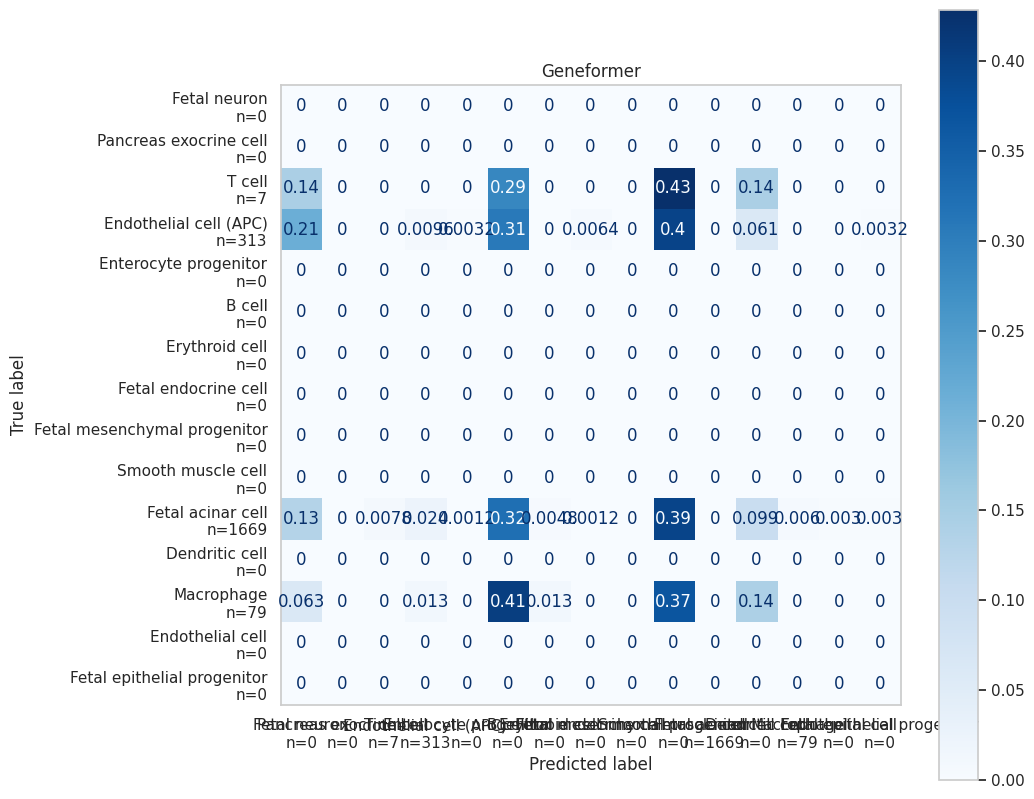

In [88]:
cc.plot_conf_mat(
    conf_mat_dict={"Geneformer": all_metrics_test["conf_matrix"]},
    output_directory=output_dir,
    output_prefix=f"newds_{input_prefix}_filtered"
)

Performance matrix

In [89]:
all_metrics_test['conf_matrix']

,Fetal neuron,Pancreas exocrine cell,T cell,Endothelial cell (APC),Enterocyte progenitor,B cell,Erythroid cell,Fetal endocrine cell,Fetal mesenchymal progenitor,Smooth muscle cell,Fetal acinar cell,Dendritic cell,Macrophage,Endothelial cell,Fetal epithelial progenitor
Fetal neuron,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Pancreas exocrine cell,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
T cell,1,0,0,0,0,2,0,0,0,3,0,1,0,0,0
Endothelial cell (APC),67,0,0,3,1,96,0,2,0,124,0,19,0,0,1
Enterocyte progenitor,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B cell,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Erythroid cell,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Fetal endocrine cell,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Fetal mesenchymal progenitor,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Smooth muscle cell,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [90]:
all_metrics_test['macro_f1']

np.float64(0.001292824822236587)

In [91]:
all_metrics_test['acc']

0.0014506769825918763

## Cell type inference on new dataset

In [96]:
embex = EmbExtractor(
    model_type="CellClassifier",
    emb_mode='cell',
    num_classes=15,
    max_ncells=sys.maxsize,
    emb_layer=0,
    emb_label=['cell_id', 'cell_type', 'input_ids', 'length'],
    labels_to_plot=["cell_type"],
    forward_batch_size=cellformer_batch_size,
    nproc=num_proc,
)

In [97]:
embs = embex.extract_embs(
    model_directory=model_directory,
    input_data_file=f"{output_dir}/newds_{input_prefix}_filtered_labeled.dataset",
    output_directory=output_dir,
    output_prefix='newds_pancreas_scib_filtered'
)
print(type(embs))

CLS token present in token dictionary, excluding from average.
EOS token present in token dictionary, excluding from average.


  0%|          | 0/517 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>


In [98]:
print(embs.head())

          0         1         2         3         4         5         6  \
0  0.870920 -2.104088 -0.553973 -1.215120  0.774325 -0.341827  1.856218   
1  1.540245 -1.419106 -0.185271 -0.956890  0.949410 -0.226274  1.784295   
2  0.999920 -2.264793 -0.742979 -1.210947  0.578635 -0.840106  1.110973   
3  0.350333 -0.441812 -0.206557 -0.361523  0.577458  0.646109  2.041981   
4  1.168259 -1.862707 -1.007016 -1.148048  0.854202 -0.773090  0.982220   

          7         8         9  ...       250       251       252       253  \
0 -0.180139 -1.003967 -1.474097  ...  0.662059  1.290252  0.089880 -0.214340   
1  0.220361 -1.180339 -1.455715  ...  0.544625  1.513412  0.834329 -0.166284   
2  0.081391 -0.389050 -1.316739  ...  0.385249  1.425151  0.617285  0.188706   
3 -0.388750 -0.893307 -2.417910  ... -0.378730  1.194173 -0.733639 -1.240363   
4  0.073571 -0.595589 -0.940489  ...  0.296253  1.290527  0.952192  0.351241   

        254       255  cell_id          cell_type  \
0  1.249759 -2.

In [99]:
embedding = embs.iloc[:, :256].values
metadata_df = embs.iloc[:, 255:]

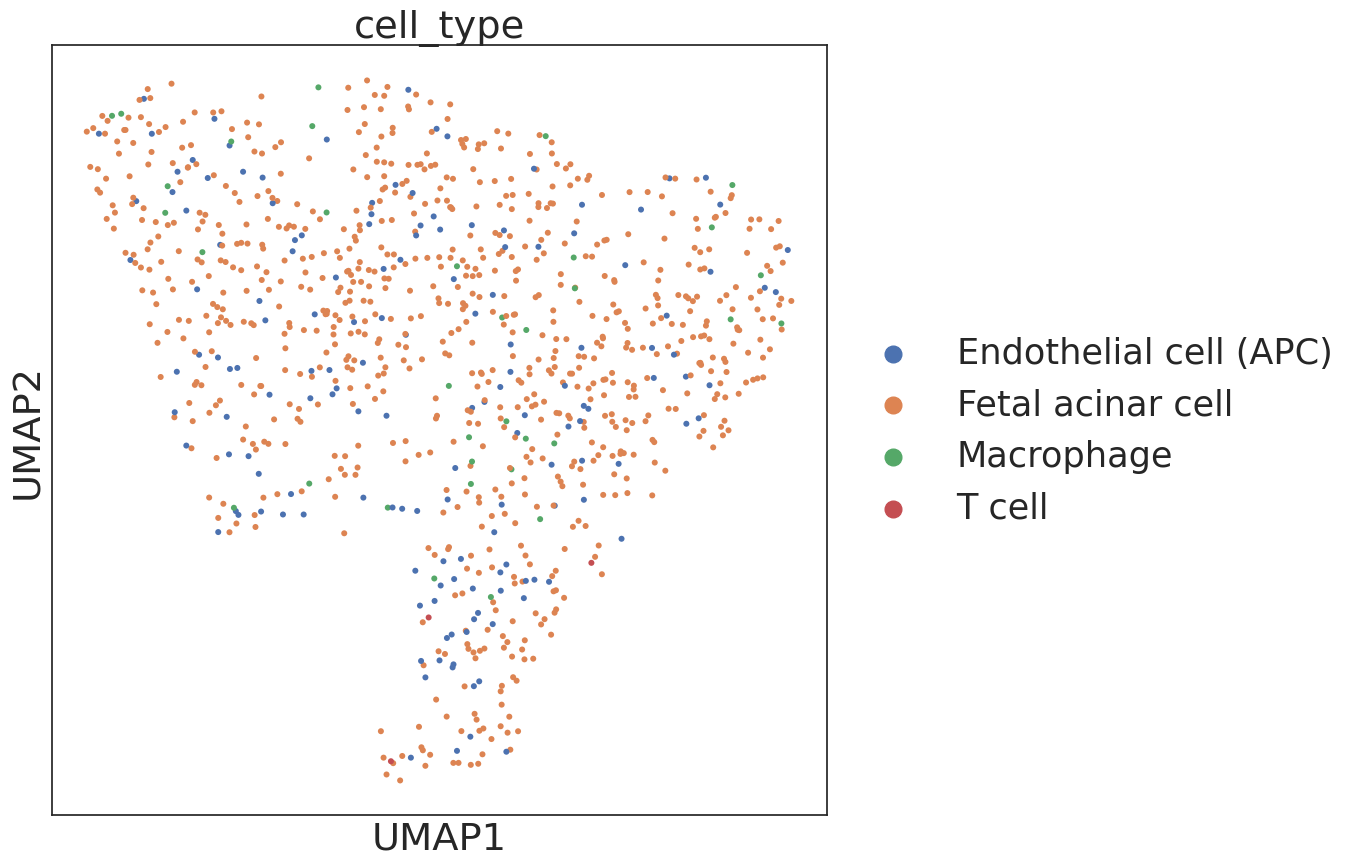

<Figure size 1000x1000 with 0 Axes>

In [100]:
embex.plot_embs(embs=embs, 
                plot_style="umap",
                output_directory="outputs",  
                output_prefix="newds_emb_plot")
# Saved to emb_plot_umap_cell_type.pdf

## References

[1] Theodoris, C.V., Xiao, L., Chopra, A. et al. Transfer learning enables predictions in network biology. Nature 618, 616–624 (2023). [https://doi.org/10.1038/s41586-023-06139-9](https://doi.org/10.1038/s41586-023-06139-9)